In [39]:
import torch
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from r3m import load_r3m
import pdb
from PIL import Image
import torchvision
from numpy import asarray
import pandas as pd
import tensorflow as tf

In [40]:
def show_images(batch: torch.Tensor, size=None):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(torch.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    images = Image.fromarray(reshaped.numpy())
    if size is not None:
        images = images.resize(size, Image.NEAREST)
    display(images)

def show_images_rlbench(batch: torch.Tensor, **kwargs):
    if batch.ndim == 3:
        batch = batch.unsqueeze(0)
    batch = batch / 255
    batch = batch * 2
    batch = batch - 1
    show_images(batch, **kwargs)
    
def show_images_ego4d(batch: torch.Tensor, **kwargs):
    if batch.ndim == 3:
        batch = batch.unsqueeze(0)
    batch = batch / 255
    batch = batch * 2
    batch = batch - 1
    show_images(batch, **kwargs)

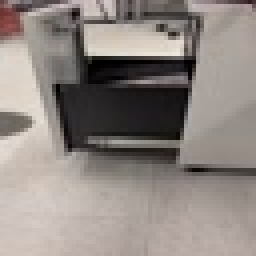

1


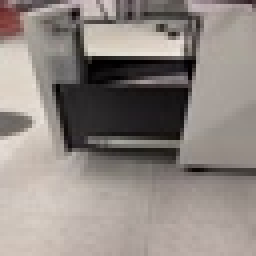

2


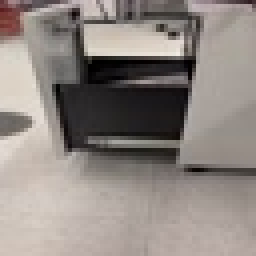

3


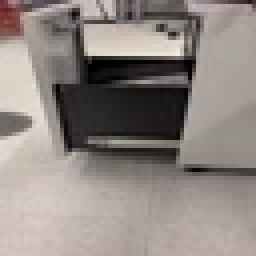

4


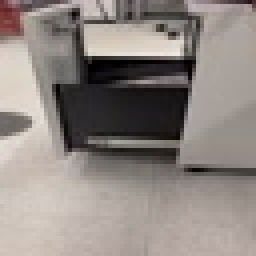

5


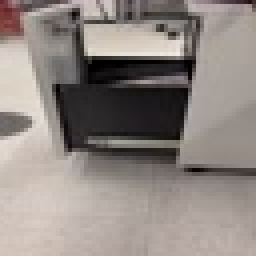

6


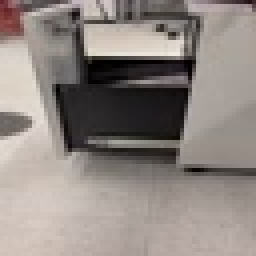

7


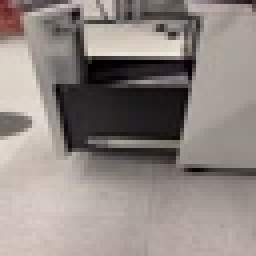

8


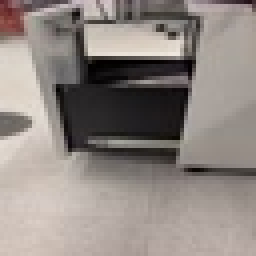

9


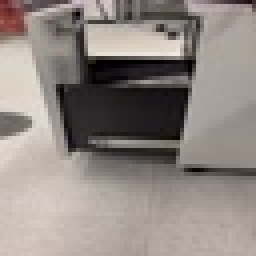

10


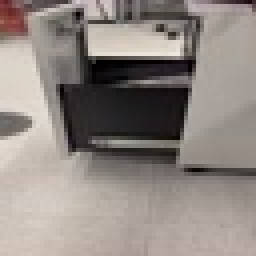

11


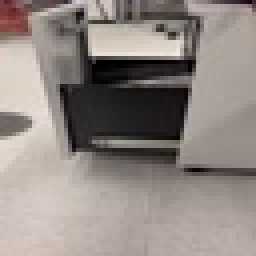

12


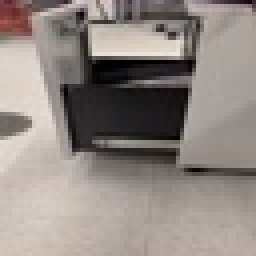

13


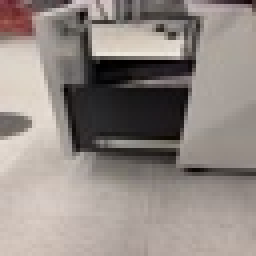

14


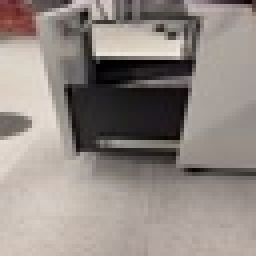

15


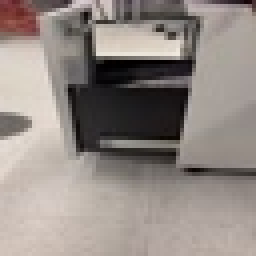

16


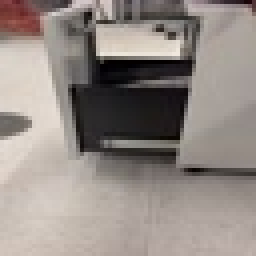

17


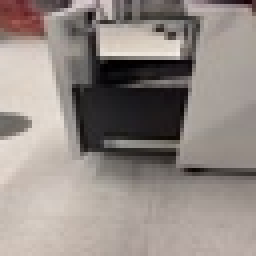

18


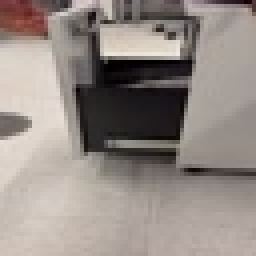

19


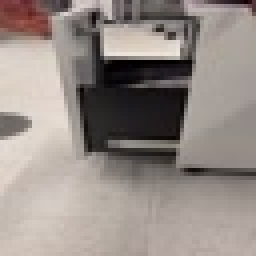

20


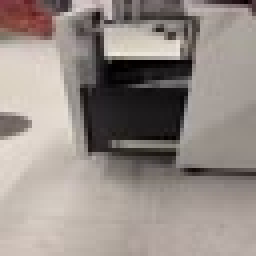

21


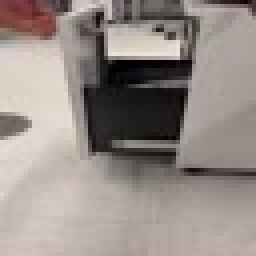

22


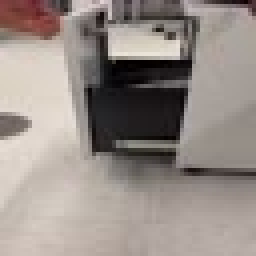

23


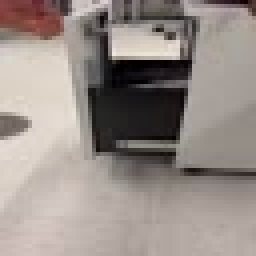

24


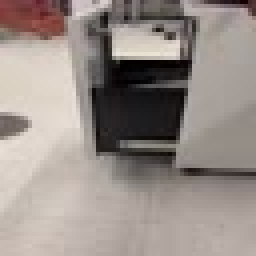

25


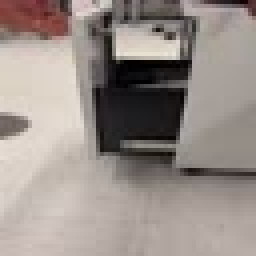

26


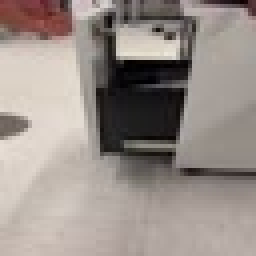

27


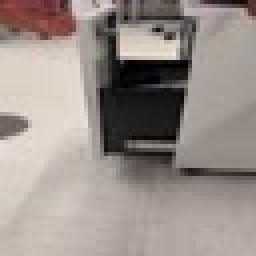

28


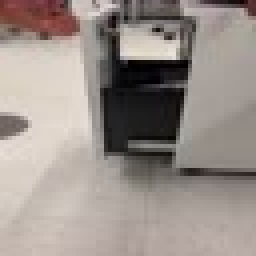

29


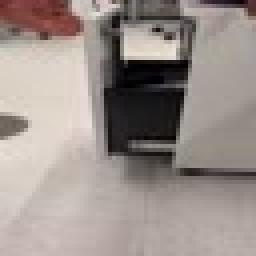

30


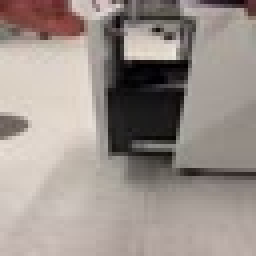

31


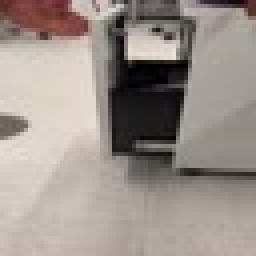

32


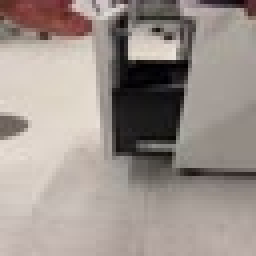

33


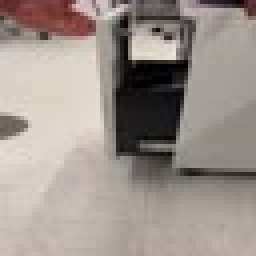

34


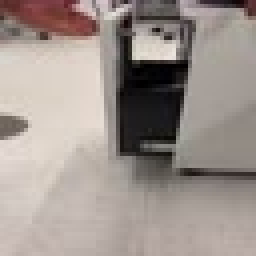

35


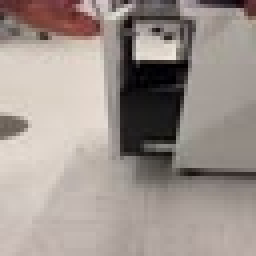

36


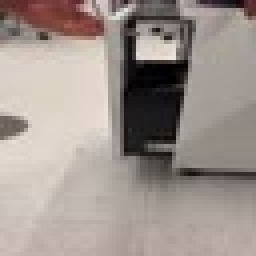

37


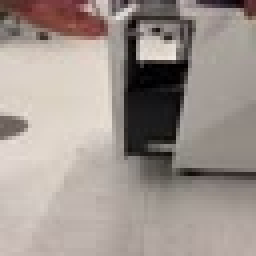

38


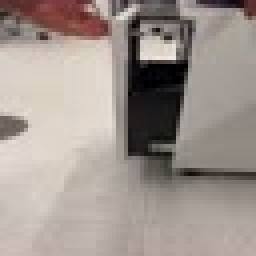

39


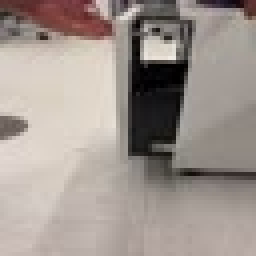

40


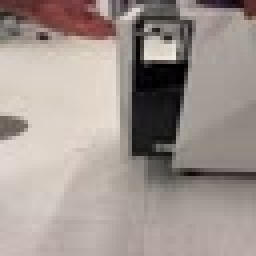

41


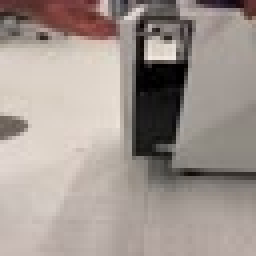

42


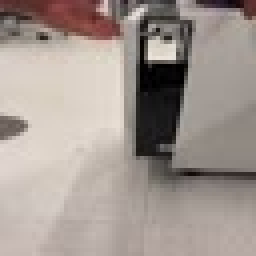

43


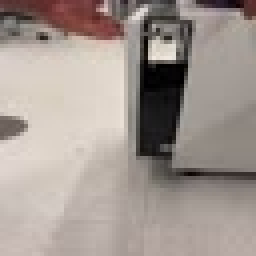

44


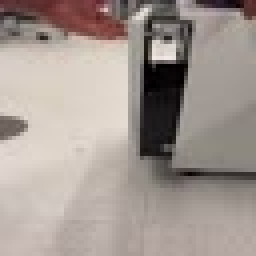

45


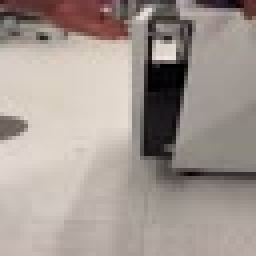

46


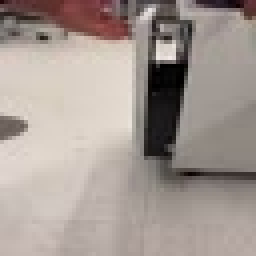

47


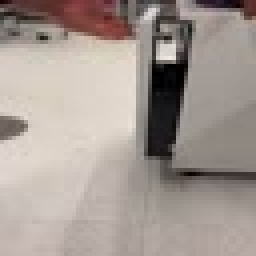

48


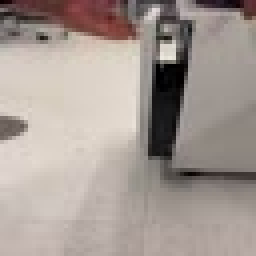

49


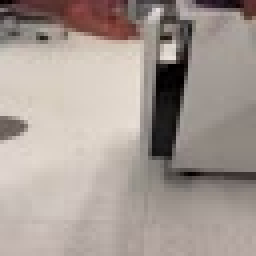

50


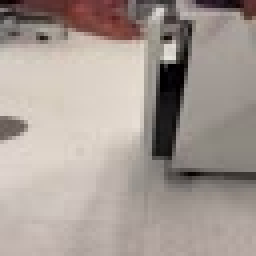

51


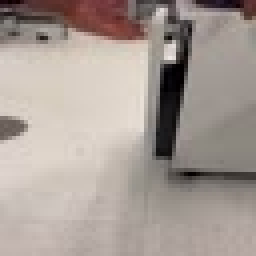

52


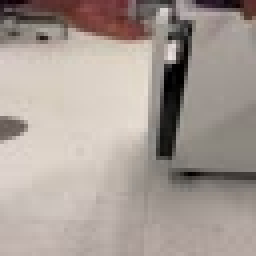

53


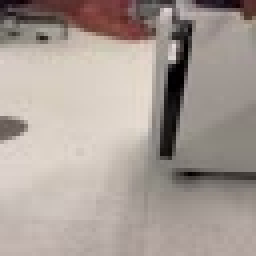

54


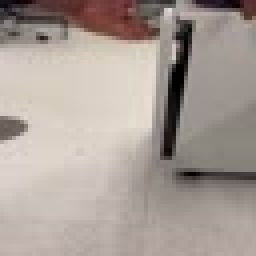

55


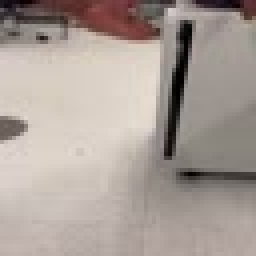

56


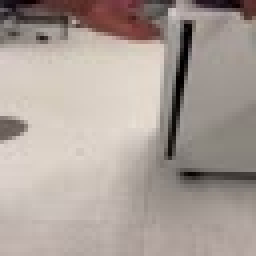

57


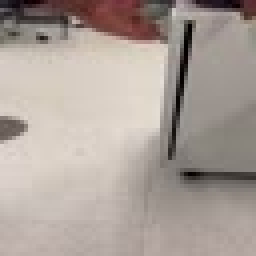

58


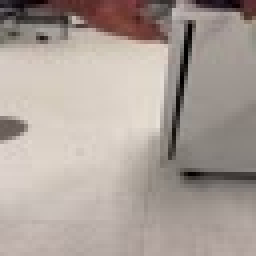

59


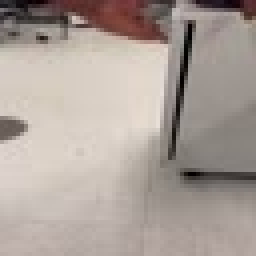

60


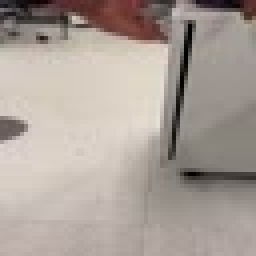

61


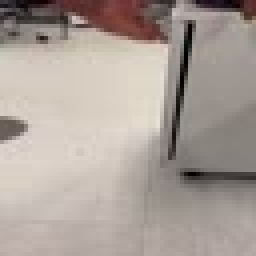

62


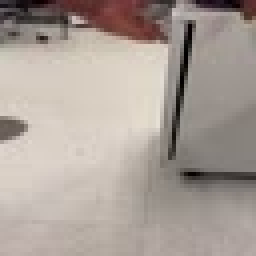

63


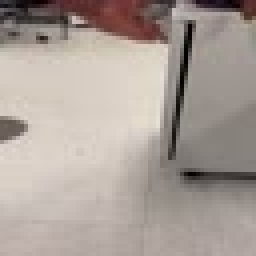

64


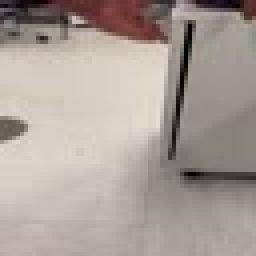

65


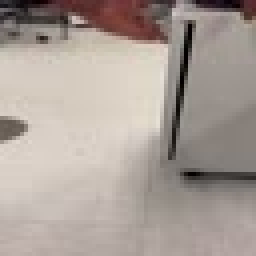

66


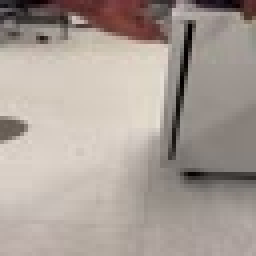

67


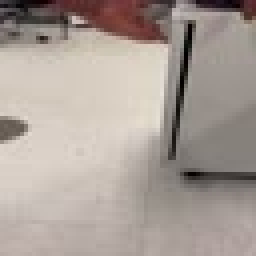

68


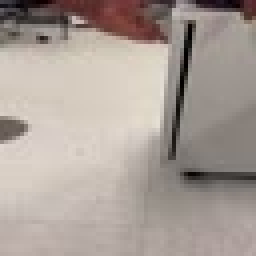

69


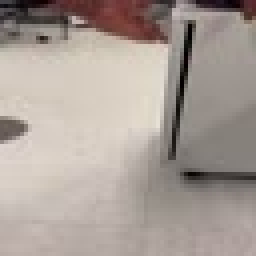

70


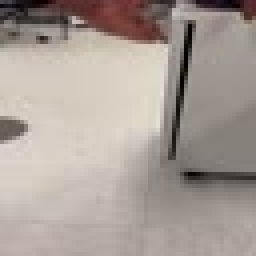

71


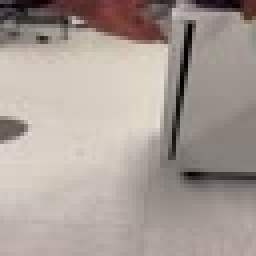

72


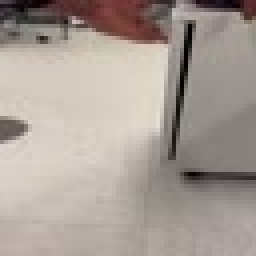

73


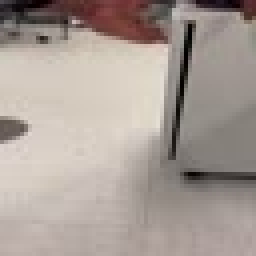

74


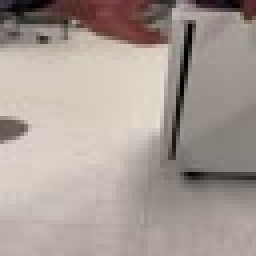

75


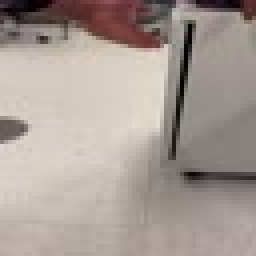

76


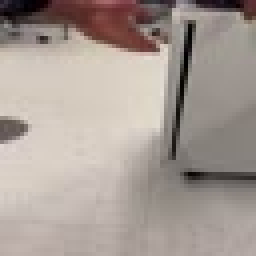

77


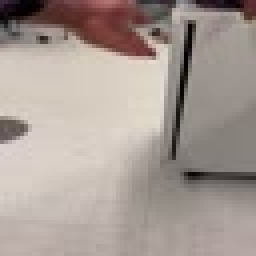

78


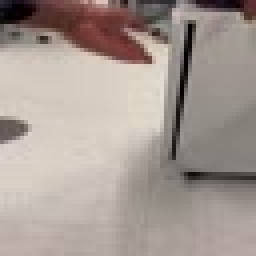

79


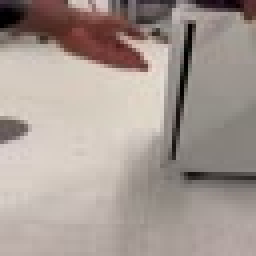

80


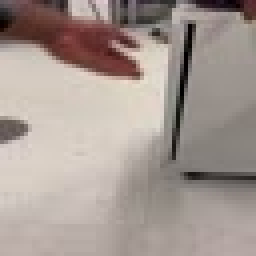

81


In [60]:
s2s_data = False
rlbench_data = False
bww_data = True
images = []
if s2s_data:
#     manifest_csv = '/home/ademi_adeniji/r3m/drawer_manifest.csv'
    manifest_csv = '/home/ademi_adeniji/r3m/drawer_manifest_eval.csv'
    csv = pd.read_csv(manifest_csv)
    labels = csv['txt'].unique()
    label = 'closing drawer'
    vid_csv = csv[csv['txt'] == label]
    vid_csv = vid_csv.sample(n=1).iloc[0]
    vidpath = vid_csv.path
    print(vidpath)
    for image in range(vid_csv.len):
        try:
            load = tf.keras.preprocessing.image.load_img(
                          vidpath+f"/{image}.jpg",
                          grayscale=False,
                          color_mode='rgb',)
        except:
            raise ValueError("Frame doesn't exist")
        images.append(load)

    ims = tf.cast(tf.stack([tf.keras.preprocessing.image.img_to_array(x) for x in images], 0), tf.float32)
    i = 0
    for im in ims:
        show_images_ego4d(torch.from_numpy(im.numpy()).permute((2, 0, 1)), size=(256, 256))
        i += 1
        print(i)
    vidlen = vid_csv.len
elif rlbench_data:
    task = 'close_drawer'
    camera = 'image_front'
    vidpath = f'/shared/ademi_adeniji/rlbench_videos/{task}/{camera}'
    vidlen = len([f for f in os.listdir(vidpath)])
    for image in range(vidlen):
        try:
            load = tf.keras.preprocessing.image.load_img(
                          vidpath+f"/{image}.jpg",
                          grayscale=False,
                          color_mode='rgb',)
        except:
            raise ValueError("Frame doesn't exist")
        images.append(load)

    ims = tf.cast(tf.stack([tf.keras.preprocessing.image.img_to_array(x) for x in images], 0), tf.float32)
    i = 0
    for im in ims:
        show_images_ego4d(torch.from_numpy(im.numpy()).permute((2, 0, 1)), size=(256, 256))
        i += 1
        print(i)
elif bww_data:
    frames = os.listdir('/home/ademi_adeniji/realvideos/frames')
#     import random
#     random_folder = random.choice(frames)
    random_folder = frames[4]
    vidpath = '/home/ademi_adeniji/realvideos/frames/' + random_folder
    num_files = len(os.listdir(vidpath))
    vidlen = num_files
    for image in range(num_files):
        try:
            load = tf.keras.preprocessing.image.load_img(
                          vidpath+f"/{image}.jpg",
                          grayscale=False,
                          color_mode='rgb',)
        except:
            raise ValueError("Frame doesn't exist")
        images.append(load)

    ims = tf.cast(tf.stack([tf.keras.preprocessing.image.img_to_array(x) for x in images], 0), tf.float32)
    i = 0
    for im in ims:
        show_images_ego4d(torch.from_numpy(im.numpy()).permute((2, 0, 1)), size=(256, 256))
        i += 1
        print(i)

In [43]:
def make_plots(model):
    label = "opening drawer"
    lang = np.array([label])
    label_inv = "closing drawer"
    label_alt = "cook food on stove"
    lang_inv = np.array([label_inv])
    lang_alt = np.array([label_alt])
    resize = torch.nn.Upsample(224, mode='bilinear', align_corners=False)
    start_idx = 0
    end_idx = vidlen-1
    start_image = torch.from_numpy(asarray(Image.open(f"{vidpath}/{start_idx}.jpg"))).permute(2, 0, 1)
    end_image = torch.from_numpy(asarray(Image.open(f"{vidpath}/{end_idx}.jpg"))).permute(2, 0, 1)
    # start_image = torch.from_numpy(asarray(Image.open(f"{vidpath}/{0}.jpg"))).permute(2, 0, 1)
    # end_image = torch.from_numpy(asarray(Image.open(f"{vidpath}/{vidlen-1}.jpg"))).permute(2, 0, 1)
    start = resize((start_image / 255.0).unsqueeze(0)) * 255.0
    start_scratch = model(start.to('cuda:0'))
    rewards_scratch = []
    rewards_scratch_inv = []
    rewards_scratch_alt = []
    for index in range(start_idx, end_idx, 1):
        end = torch.from_numpy(asarray(Image.open(f"{vidpath}/{index}.jpg"))).permute(2, 0, 1)
        end = resize((end / 255.0).unsqueeze(0)) * 255.0
        end_scratch = model(end.to('cuda:0'))
        rewards_scratch.append(model.module.get_reward(start_scratch, end_scratch, lang)[0].cpu().detach())
        rewards_scratch_inv.append(model.module.get_reward(start_scratch, end_scratch, lang_inv)[0].cpu().detach())
        rewards_scratch_alt.append(model.module.get_reward(start_scratch, end_scratch, lang_alt)[0].cpu().detach())

    show_images_rlbench(torch.stack([start_image, end_image]), size=(512, 256))
    fig, axs = plt.subplots(1,3, sharex=True, sharey=False, figsize=(10, 7))
    axs[0].plot(rewards_scratch)
    axs[0].set(xlabel="num frames from start frame", ylabel="reward")
    axs[0].set_title(label)

    axs[1].plot(rewards_scratch_inv)
    axs[1].set(xlabel="num frames from start frame", ylabel="reward")
    axs[1].set_title(label_inv)

    axs[2].plot(rewards_scratch_alt)
    axs[2].set(xlabel="num frames from start frame", ylabel="reward")
    axs[2].set_title(label_alt)
    plt.show()
    plt.clf()
    plt.plot(rewards_scratch, label=label)
    plt.plot(rewards_scratch_inv, label=label_inv)
    plt.plot(rewards_scratch_alt, label=label_alt)
    plt.ylabel("reward")
    plt.xlabel("frames from beginning")
    plt.legend()

    fig.tight_layout()

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
snapshot_scratch = "/shared/ademi_adeniji/r3m/r3m/r3moutput/train_representation/2022-07-27_18-08-35/snapshot_0.pt"
r3m_scratch = load_r3m('resnet50', snapshot_scratch).to('cuda:0')
r3m_scratch.eval()

/home/ademi_adeniji/anaconda3/envs/sr3m_base/lib/python3.9/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DataParallel(
  (module): R3M(
    (cs): CosineSimilarity()
    (bce): BCELoss()
    (sigm): Sigmoid()
    (convnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1

In [7]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"
snapshot_drawer = "/home/ademi_adeniji/r3m/r3m/r3moutput/train_representation/2023-02-16_03-26-12/snapshot_40000.pt"
r3m_drawer = load_r3m('resnet50', snapshot_drawer).to('cuda:0')
r3m_drawer.eval()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DataParallel(
  (module): R3M(
    (cs): CosineSimilarity()
    (bce): BCELoss()
    (sigm): Sigmoid()
    (convnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1

In [8]:
os.environ["CUDA_VISIBLE_DEVICES"]="3"
snapshot_drawer_ft = "/home/ademi_adeniji/r3m/r3m/r3moutput/train_representation/2023-02-16_03-30-35/snapshot_40000.pt"
r3m_drawer_ft = load_r3m('resnet50', snapshot_drawer_ft).to('cuda:0')
r3m_drawer_ft.eval()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DataParallel(
  (module): R3M(
    (cs): CosineSimilarity()
    (bce): BCELoss()
    (sigm): Sigmoid()
    (convnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"]="4"
snapshot_drawer_medium_ft = "/home/ademi_adeniji/r3m/r3m/r3moutput/train_representation/2023-02-19_08-07-09/snapshot_50000.pt"
r3m_drawer_medium_ft = load_r3m('resnet50', snapshot_drawer_medium_ft).to('cuda:0')
r3m_drawer_medium_ft.eval()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DataParallel(
  (module): R3M(
    (cs): CosineSimilarity()
    (bce): BCELoss()
    (sigm): Sigmoid()
    (convnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1

In [10]:
os.environ["CUDA_VISIBLE_DEVICES"]="5"
snapshot_drawer_heavy = "/home/ademi_adeniji/r3m/r3m/r3moutput/train_representation/2023-02-19_07-55-11/snapshot_50000.pt"
r3m_drawer_heavy = load_r3m('resnet50', snapshot_drawer_heavy).to('cuda:0')
r3m_drawer_heavy.eval()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DataParallel(
  (module): R3M(
    (cs): CosineSimilarity()
    (bce): BCELoss()
    (sigm): Sigmoid()
    (convnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1

In [13]:
os.environ["CUDA_VISIBLE_DEVICES"]="6"
snapshot_drawer_heavy_ft = "/home/ademi_adeniji/r3m/r3m/r3moutput/train_representation/2023-02-19_07-55-22/snapshot_50000.pt"
r3m_drawer_heavy_ft = load_r3m('resnet50', snapshot_drawer_heavy_ft).to('cuda:0')
r3m_drawer_heavy_ft.eval()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DataParallel(
  (module): R3M(
    (cs): CosineSimilarity()
    (bce): BCELoss()
    (sigm): Sigmoid()
    (convnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]="7"
snapshot_drawer_split_ft = "/home/ademi_adeniji/r3m/r3m/r3moutput/train_representation/2023-02-22_17-09-42/snapshot_10000.pt"
r3m_drawer_split_ft = load_r3m('resnet50', snapshot_drawer_split_ft).to('cuda:0')
r3m_drawer_split_ft.eval()


/home/ademi_adeniji/anaconda3/envs/sr3m_base/lib/python3.9/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DataParallel(
  (module): R3M(
    (cs): CosineSimilarity()
    (bce): BCELoss()
    (sigm): Sigmoid()
    (convnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1

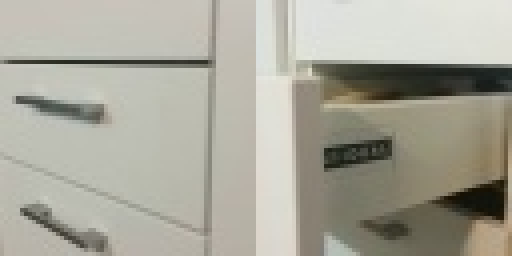

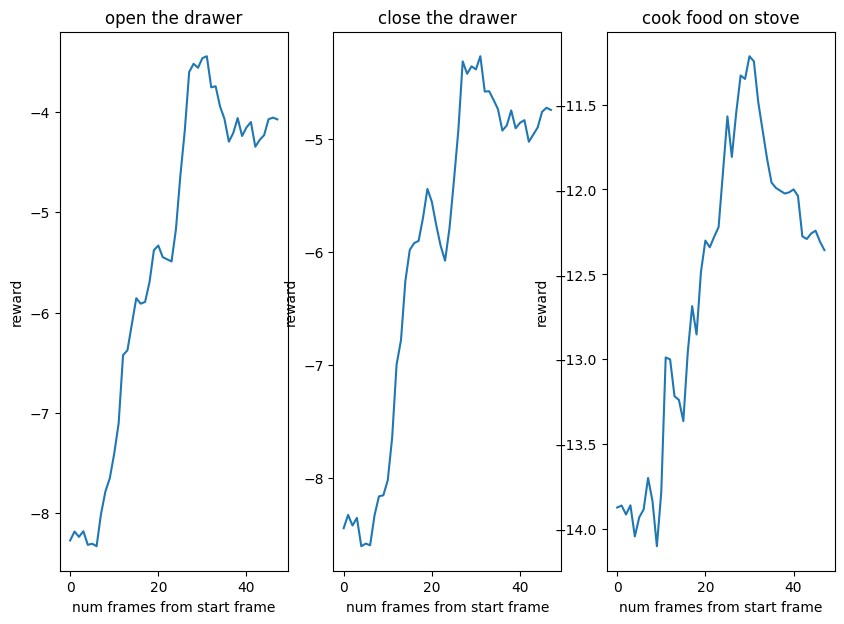

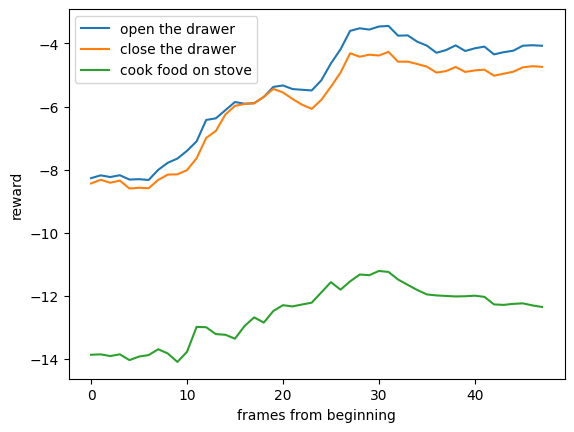

In [45]:
make_plots(r3m_scratch)

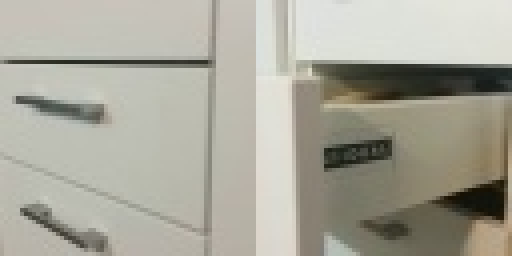

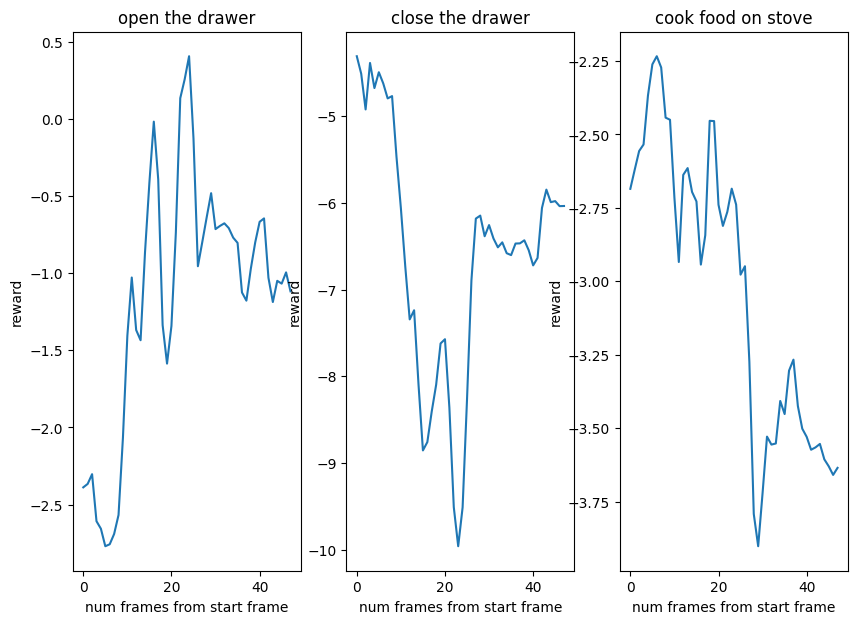

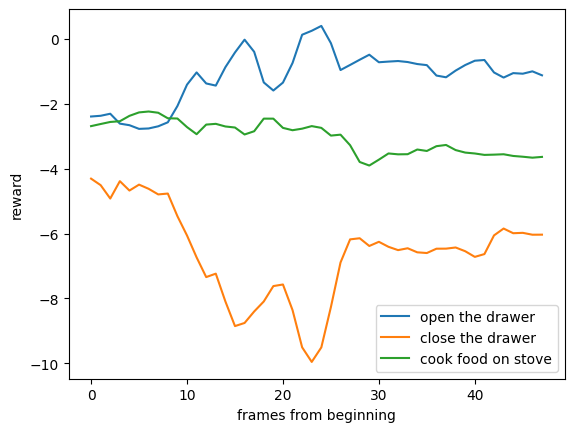

In [46]:
make_plots(r3m_drawer)

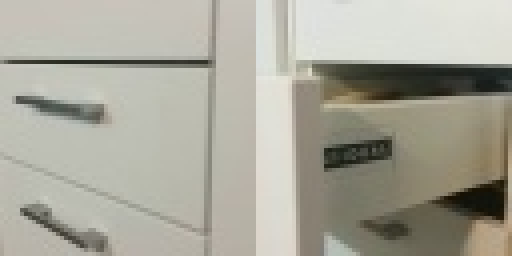

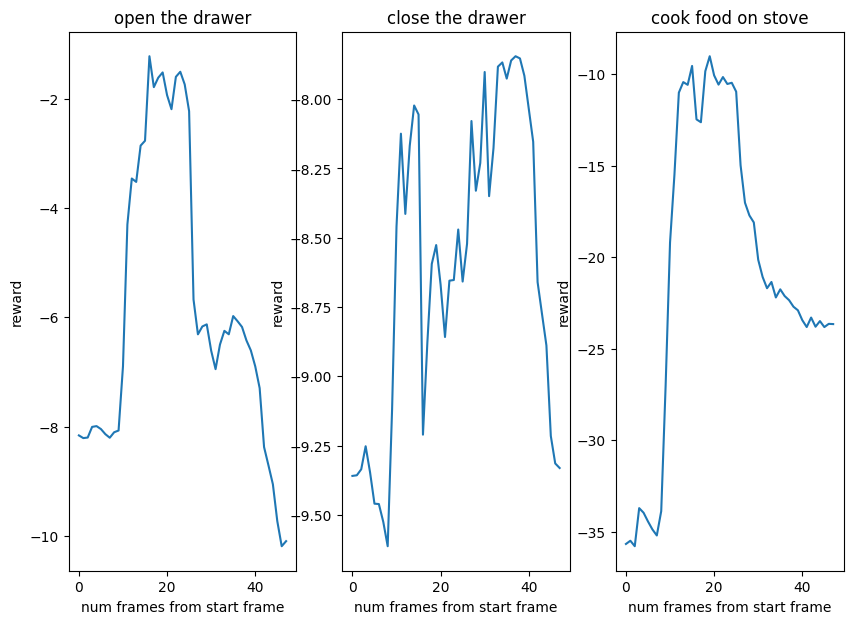

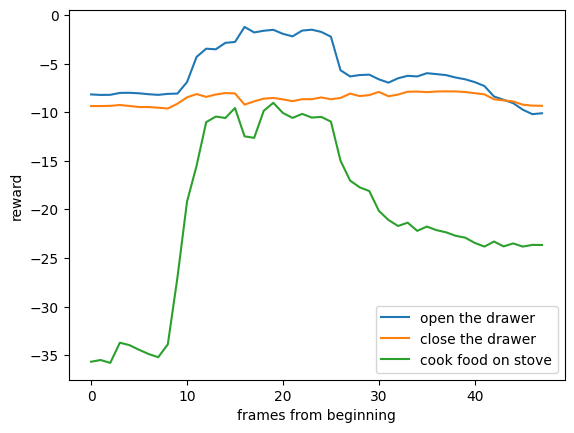

In [47]:
make_plots(r3m_drawer_ft)

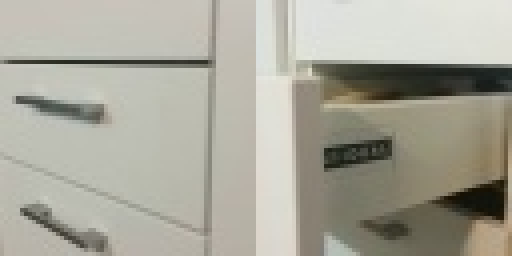

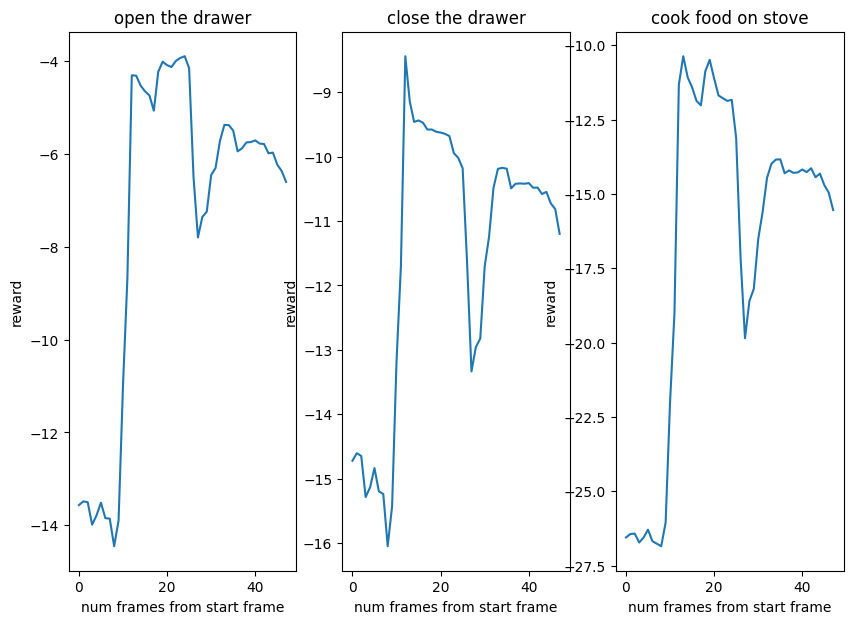

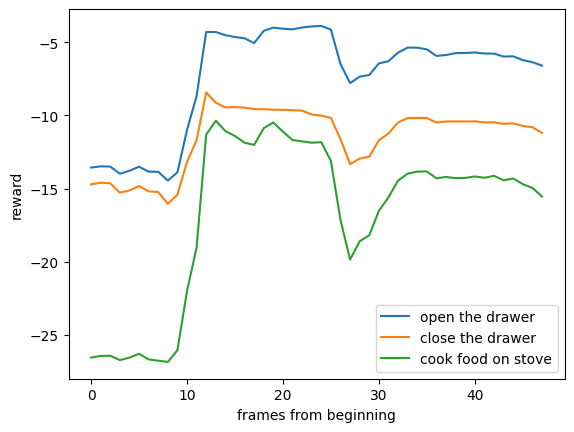

In [48]:
make_plots(r3m_drawer_medium_ft)

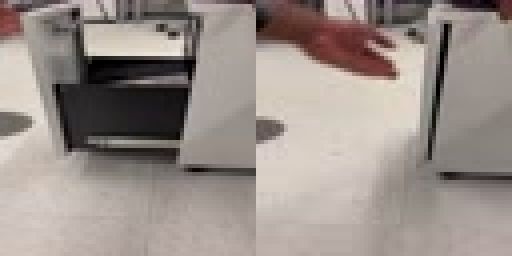

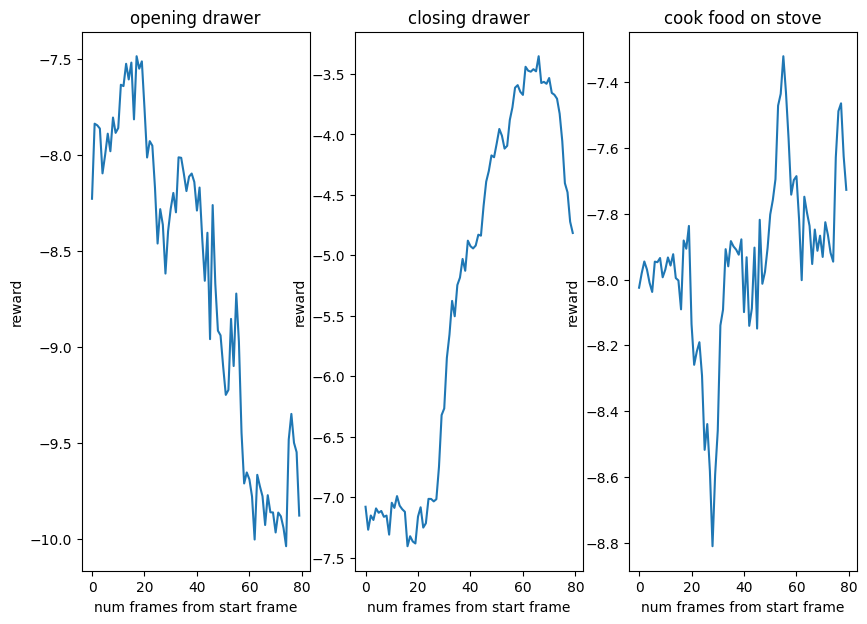

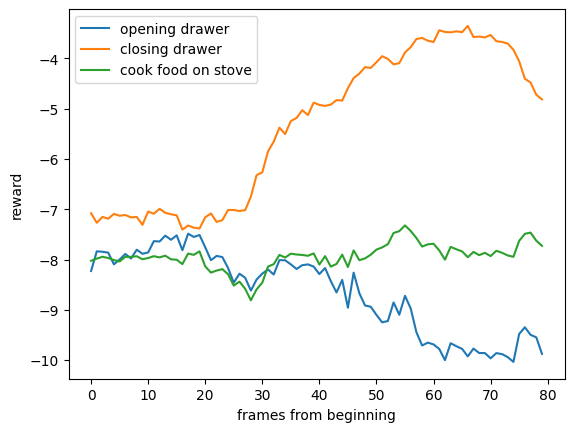

In [61]:
make_plots(r3m_drawer_split_ft)

In [ ]:
# make_plots(r3m_drawer_heavy)
# make_plots(r3m_drawer_heavy_ft)